## Import Libraries

In [7]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 , ResNet50 , ConvNeXtBase , DenseNet201
import matplotlib.pyplot as plt

In [2]:
# Image Params
folder_name = 'ExDark_Converted' # Location Folder
height = 256
width = 256
channels  = 3
format = 'rgb' # Image Format

### Create train dataset

In [3]:
df = pd.DataFrame(data= None , columns= ['label' , 'filename'])
dataset_path = os.getcwd().replace('notebook' , '') + folder_name
count = 0
for folder in [i for i in os.listdir(dataset_path) if i not in ['.DS_Store' , 'label.csv']]:
    for i , file in enumerate(os.listdir(dataset_path + '/' + folder)):
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                  df.loc[count + i] = [folder, file]
            count += len(os.listdir(dataset_path + '/' + folder))
df.to_csv(os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv')

## Pre Processing

In [4]:
label_df_path = os.getcwd().replace('notebook' , '') + folder_name + '/' + 'label.csv' 
df = pd.read_csv(label_df_path , index_col=0)

# One Hot Encode genre file
df_encoded = pd.get_dummies(df['label'], columns=['label'])

y = df_encoded.values

### Metric Visualisation

In [5]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['categorical_accuracy'])
  plt.plot(epochRange,history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

## Modelling

### VGG16

#### Image Processing

In [21]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:00<00:00, 1026.43it/s]


### Tranfer Learning weights freezed

In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │   134,221,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,738,309 (632.24 MB)

 Trainable params: 151,023,621 (576.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
est = model.fit(x_train,y_train , epochs=20 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - categorical_accuracy: 0.2504 - loss: 54.3934 - val_categorical_accuracy: 0.4874 - val_loss: 10.3115
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - categorical_accuracy: 0.8615 - loss: 2.2712 - val_categorical_accuracy: 0.6555 - val_loss: 4.4952
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - categorical_accuracy: 0.9895 - loss: 0.1500 - val_categorical_accuracy: 0.7143 - val_loss: 4.0783
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - categorical_accuracy: 0.9974 - loss: 0.0049 - val_categorical_accuracy: 0.7479 - val_loss: 3.1696
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - categorical_accuracy: 1.0000 - loss: 1.9839e-04 - val_categorical_accuracy: 0.7731 - val_loss: 2.9083
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - categorical_accuracy: 1.0000 - loss: 1.0227e-05 - val_categorical_accuracy: 0.7731 - val_loss: 2.8685
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - categorical_accuracy: 1.0000 - loss: 1

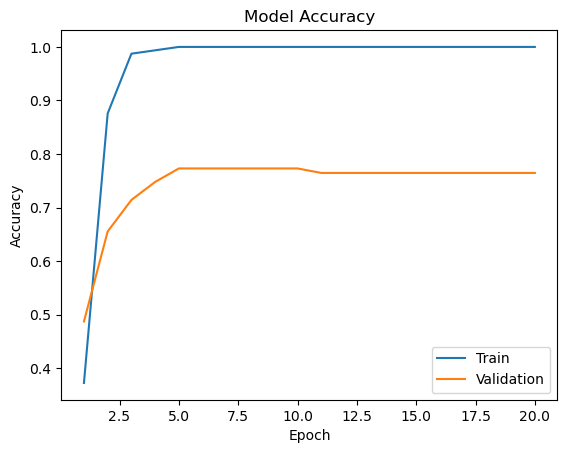

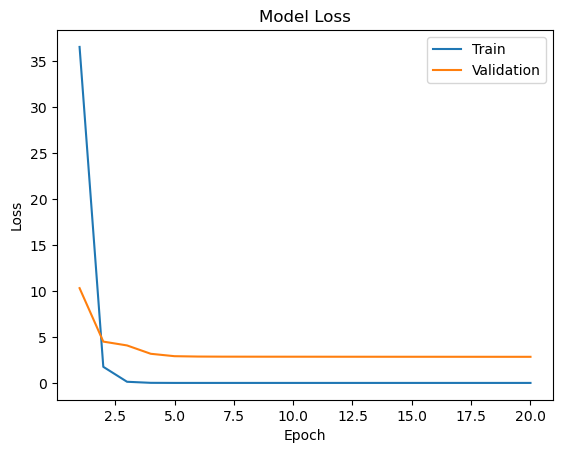

In [25]:
plotLearningCurve(est,20)

### ResNet50

#### Image Processing

In [26]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:00<00:00, 988.22it/s] 


In [27]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
est = model.fit(x_train,y_train , epochs=50 , batch_size=32 , validation_data=(x_test,y_test))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - categorical_accuracy: 0.4040 - loss: 3.4103 - val_categorical_accuracy: 0.6555 - val_loss: 0.9485
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 995ms/step - categorical_accuracy: 0.7999 - loss: 0.4848 - val_categorical_accuracy: 0.7479 - val_loss: 0.6982
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 950ms/step - categorical_accuracy: 0.9116 - loss: 0.2346 - val_categorical_accuracy: 0.7899 - val_loss: 0.6849
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 921ms/step - categorical_accuracy: 0.9759 - loss: 0.1090 - val_categorical_accuracy: 0.8067 - val_loss: 0.6508
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 924ms/step - categorical_accuracy: 0.9857 - loss: 0.0629 - val_categorical_accuracy: 0.8067 - val_loss: 0.6734
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 944ms/step - categorical_accuracy: 1.0000 - loss: 0.0302 - val_categorical_accuracy: 0.8067 - val_loss: 0.7039
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 999ms/step - categorical_accuracy: 1.0000 -

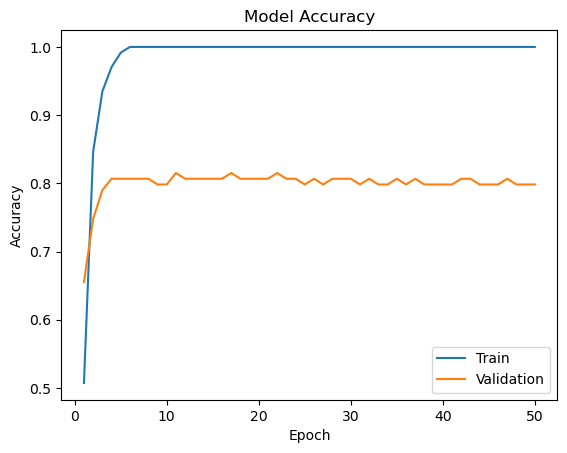

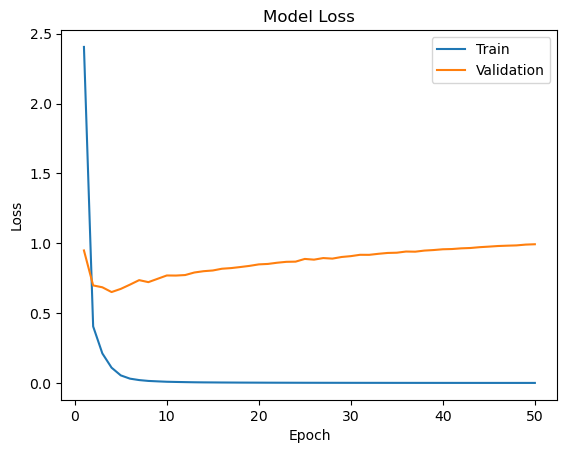

In [30]:
plotLearningCurve(est,50)

### ConvNeXt

#### Image Processing

In [16]:
from tensorflow.keras.applications.convnext import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:00<00:00, 1364.97it/s]


In [17]:
base_model = ConvNeXtBase(weights="imagenet", include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.LayerNormalization(epsilon=1e-6),
    layers.Dense(1024, activation="gelu"),
    layers.Dense(5, activation='softmax')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 8, 8, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 1024)           │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,623,237 (338.07 MB)

 Trainable params: 1,056,773 (4.03 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
est = model.fit(x_train , y_train , epochs = 50 , batch_size = 32 , validation_data = (x_test,y_test))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 453s 31s/step - categorical_accuracy: 0.4142 - loss: 1.4205 - val_categorical_accuracy: 0.7899 - val_loss: 0.6612
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 458s 31s/step - categorical_accuracy: 0.9102 - loss: 0.4316 - val_categorical_accuracy: 0.8487 - val_loss: 0.4008
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 453s 31s/step - categorical_accuracy: 0.9692 - loss: 0.2036 - val_categorical_accuracy: 0.8655 - val_loss: 0.3359
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 456s 31s/step - categorical_accuracy: 0.9849 - loss: 0.1188 - val_categorical_accuracy: 0.8739 - val_loss: 0.3138
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 452s 31s/step - categorical_accuracy: 0.9958 - loss: 0.0801 - val_categorical_accuracy: 0.8824 - val_loss: 0.2955
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 448s 30s/step - categorical_accuracy: 0.9989 - loss: 0.0561 - val_categorical_accuracy: 0.8824 - val_loss: 0.2829
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 459s 31s/step - categorical_accuracy: 0.9969 - los

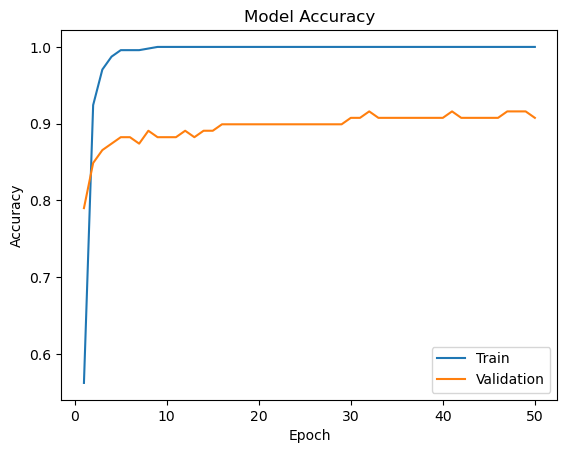

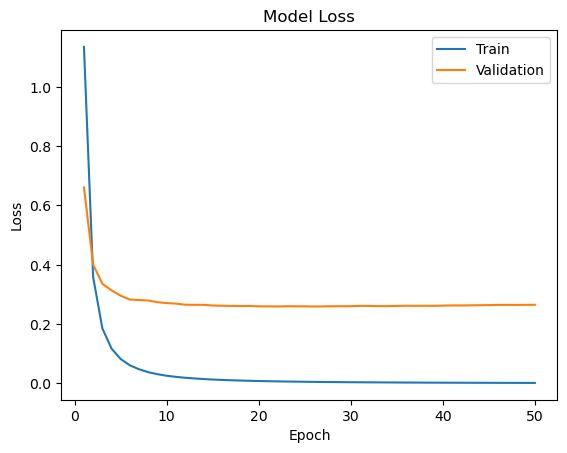

In [20]:
plotLearningCurve(est,50)

### DenseNet

#### Image Processing

In [6]:
from tensorflow.keras.applications.densenet import preprocess_input

x = []
for i in tqdm(range(len(df))):
    label = df['label'].iloc[i]
    filename = df['filename'].iloc[i]
    filepath = os.path.join(os.getcwd().replace('notebook', ''), folder_name, label, filename)
    img = image.load_img(filepath, target_size=(height, width) , color_mode = format)
    
    # Convert to array and add batch dimension
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG-specific preprocessing (RGB → BGR + mean subtraction)
    img_preprocessed = preprocess_input(img_array)
    x.append(img)
x = np.array(x)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size= 0.2)

100%|██████████| 594/594 [00:00<00:00, 929.65it/s]


In [14]:
base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(height, width, channels))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.LayerNormalization(epsilon=1e-6),
    layers.Dense(1920, activation="gelu"),
    layers.Dense(5, activation='softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 8, 8, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 1920)           │         3,840 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1920)           │     3,688,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         9,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,023,749 (84.01 MB)

 Trainable params: 3,701,765 (14.12 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
est = model.fit(x_train , y_train , epochs = 50 , batch_size = 32 , validation_data = (x_test,y_test))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - categorical_accuracy: 0.3022 - loss: 1.6536 - val_categorical_accuracy: 0.4454 - val_loss: 1.4644
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - categorical_accuracy: 0.5403 - loss: 1.2319 - val_categorical_accuracy: 0.4622 - val_loss: 1.3405
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - categorical_accuracy: 0.6403 - loss: 1.0163 - val_categorical_accuracy: 0.5126 - val_loss: 1.1643
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - categorical_accuracy: 0.6720 - loss: 0.8718 - val_categorical_accuracy: 0.5210 - val_loss: 1.1649
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - categorical_accuracy: 0.7478 - loss: 0.7693 - val_categorical_accuracy: 0.5294 - val_loss: 1.1766
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - categorical_accuracy: 0.8246 - loss: 0.6452 - val_categorical_accuracy: 0.5546 - val_loss: 1.1669
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - categorical_accuracy: 0.8082 - loss: 0.6084 - va